In [27]:
%pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


mnist = fetch_openml("mnist_784", version=1)


In [3]:
import numpy as np

X_train = mnist['data'].to_numpy()


def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))


## PCA

In [6]:
import tensorflow as tf
tf.keras.datasets.mnist.load_data(path="mnist.npz")

(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()

2023-06-06 14:33:43.374898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-06 14:33:43.374938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [45]:
cov_mat = np.cov(X_train, rowvar=False)

In [50]:
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

#sort the eigenvalues in descending order
sorted_index = np.argsort(eigen_values)[::-1]
 
sorted_eigenvalue = eigen_values[sorted_index]
#similarly sort the eigenvectors 
sorted_eigenvectors = eigen_vectors[:,sorted_index]

In [51]:
def display_mnist(xs, row: int = None, col: int = None, width: int = None):
    if row:
        if not width:
            width = 3 * (row + 1) if row else 12
        fig, axes = plt.subplots(row + 1, col, figsize=(12, width))
    else:
        fig, axes = plt.subplots((xs.shape[0] // 4) + 1, 4, figsize=(12, 3*((xs.shape[0] // 4) + 1)))
    axes = axes.flatten()

    for i in range(len(xs)):
        axes[i].imshow(xs[i], cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [60]:
import copy

def passbyval(func):
  def new(*args):
      cargs = [copy.deepcopy(arg) for arg in args]
      return func(*cargs)
  return new

@passbyval
def loop(minmax, steps, deep, arr, i, fullarr):
  index = i
  it = minmax[deep][0]
  step = steps[deep]
  while it < minmax[deep][1]:
    try:
      arr[i] = copy.deepcopy(it)
    except:
      arr.append(it)
    if deep < len(steps) - 1:
      fullarr = copy.deepcopy(loop(minmax, steps, deep + 1, arr, index + 1, fullarr))
    else:
      fullarr.append(copy.deepcopy(arr))
    it += step
  return(fullarr)

class PCA:
  def __init__(self, n_values: int = 3):
    self._n_values_ = n_values

  def process(self, data):
    # Flatten the images into vectors
    data = data.reshape(data.shape[0], -1)
    # Convert data to float and scale it between 0 and 1
    data = data.astype(float) / 255.0
    # Calculate the mean vector
    self._mean_vector_ = np.mean(data, axis=0)
    # Subtract the mean vector from the data
    X_centered = data - self._mean_vector_
    return (X_centered)

  def fit(self, X):
    self._cov_mat_ = np.cov(X, rowvar=False)
    eigen_values , eigen_vectors = np.linalg.eigh(self._cov_mat_)

    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    
    self._sorted_eigenvalue_ = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    self._sorted_eigenvectors_ = eigen_vectors[:,sorted_index]

    self._eigenvectors_sub_ = self._sorted_eigenvectors_[:,0:self._n_values_]
    self.X_reduced = np.dot(self._eigenvectors_sub_.transpose(),X.transpose()).transpose()

    return self.X_reduced
  
  @property
  def eigs(self):
    return self._eigenvectors_sub_
  
  def generate(self, x_base = None, rand: bool = False, n: int = 12):
    # (rows, cols) = self.X_reduced.shape
    # print (rows, cols)
    if rand:
      min_x = self.X_reduced.flatten().min()
      max_x = self.X_reduced.flatten().max()
      x_to_gen = []
      for i in range(10):
        x_to_gen.append(np.random.uniform(low=min_x, high=max_x, size=(self._n_values_,)))
      x_to_gen = np.array(x_to_gen)
    x_gen = np.dot(x_to_gen if rand else x_base, self._eigenvectors_sub_.T) + self._mean_vector_
    return (x_gen)
  
  def display_table(self, max_image: int = 500):
    x_t_img = self.X_reduced.T

    min_max = [(xti.min(), xti.max()) for xti in x_t_img]

    stepn = int(max_image**(1/self._n_values_))

    steps = [(mx - mn) / stepn for (mn, mx) in min_max]
    arr1 = []
    arr2 = []

    print(min_max, steps, stepn)

    x_base_gen = loop(min_max, steps, 0, arr1, 0, arr2)
    print(x_base_gen)
    x_base_gen = np.array(x_base_gen)
    x_generate = self.generate(x_base_gen)
    print(x_generate.shape)
    x_generate = x_generate.reshape(x_generate.shape[0], 28, 28)
    print(x_generate)
    display_mnist(x_generate, stepn, stepn)

        

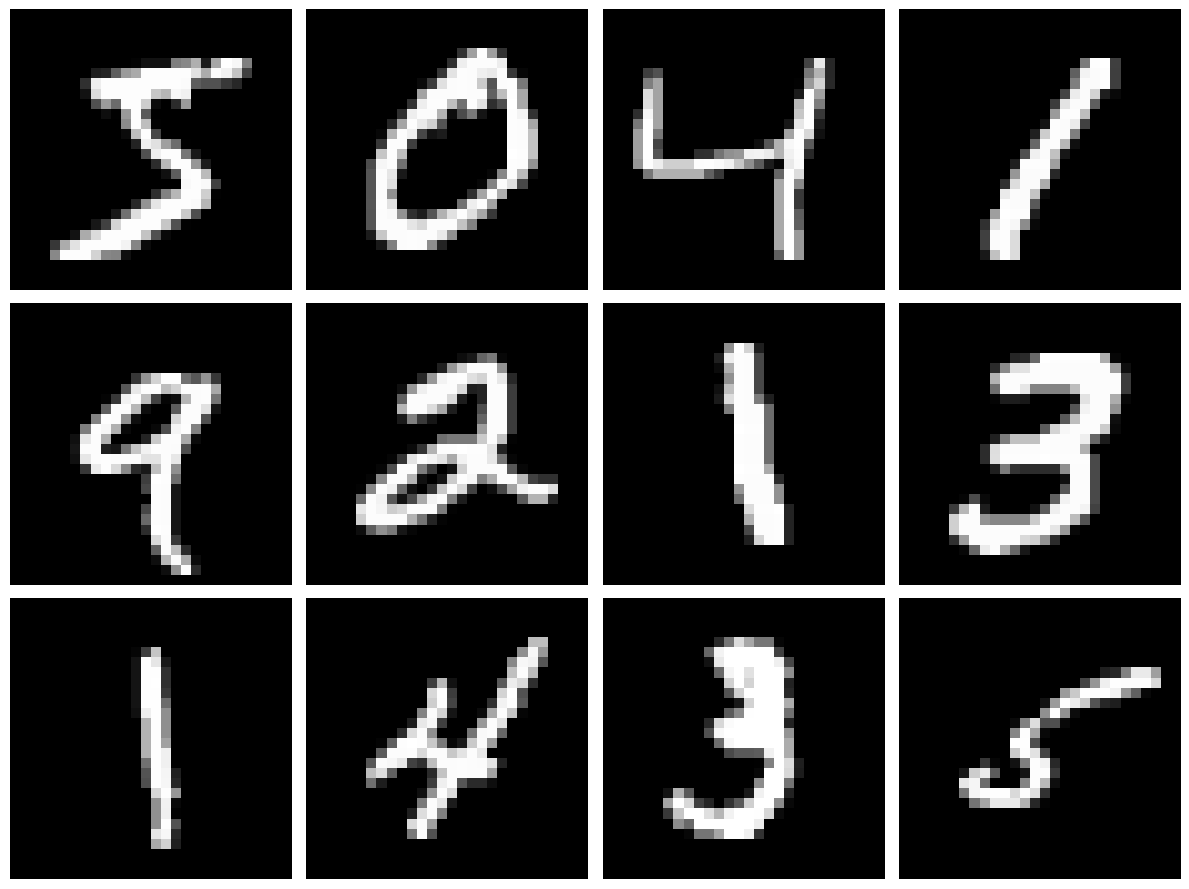

In [62]:
pca = PCA(6)
x_img = np.concatenate((x_tr, x_te), axis=0)
print(x_img.shape)
x_img_process = pca.process(x_img)
x_red = pca.fit(x_img_process)

x_red.shape

(70000, 28, 28)


(70000, 6)

10


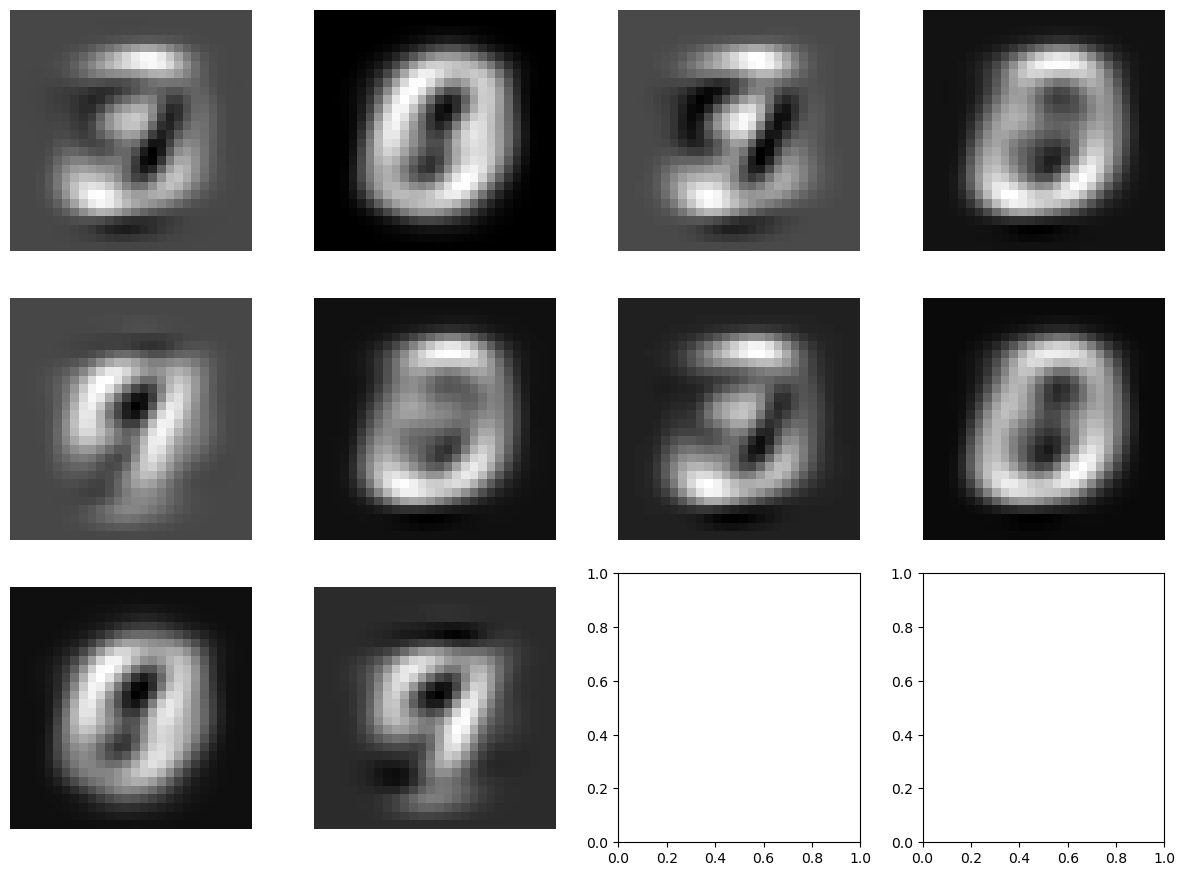

In [12]:
x_gen = pca.generate(rand=True)
print(x_gen.shape[0])
x_gen = x_gen.reshape(x_gen.shape[0], 28, 28)
display_mnist(x_gen)

(110, 28, 28)


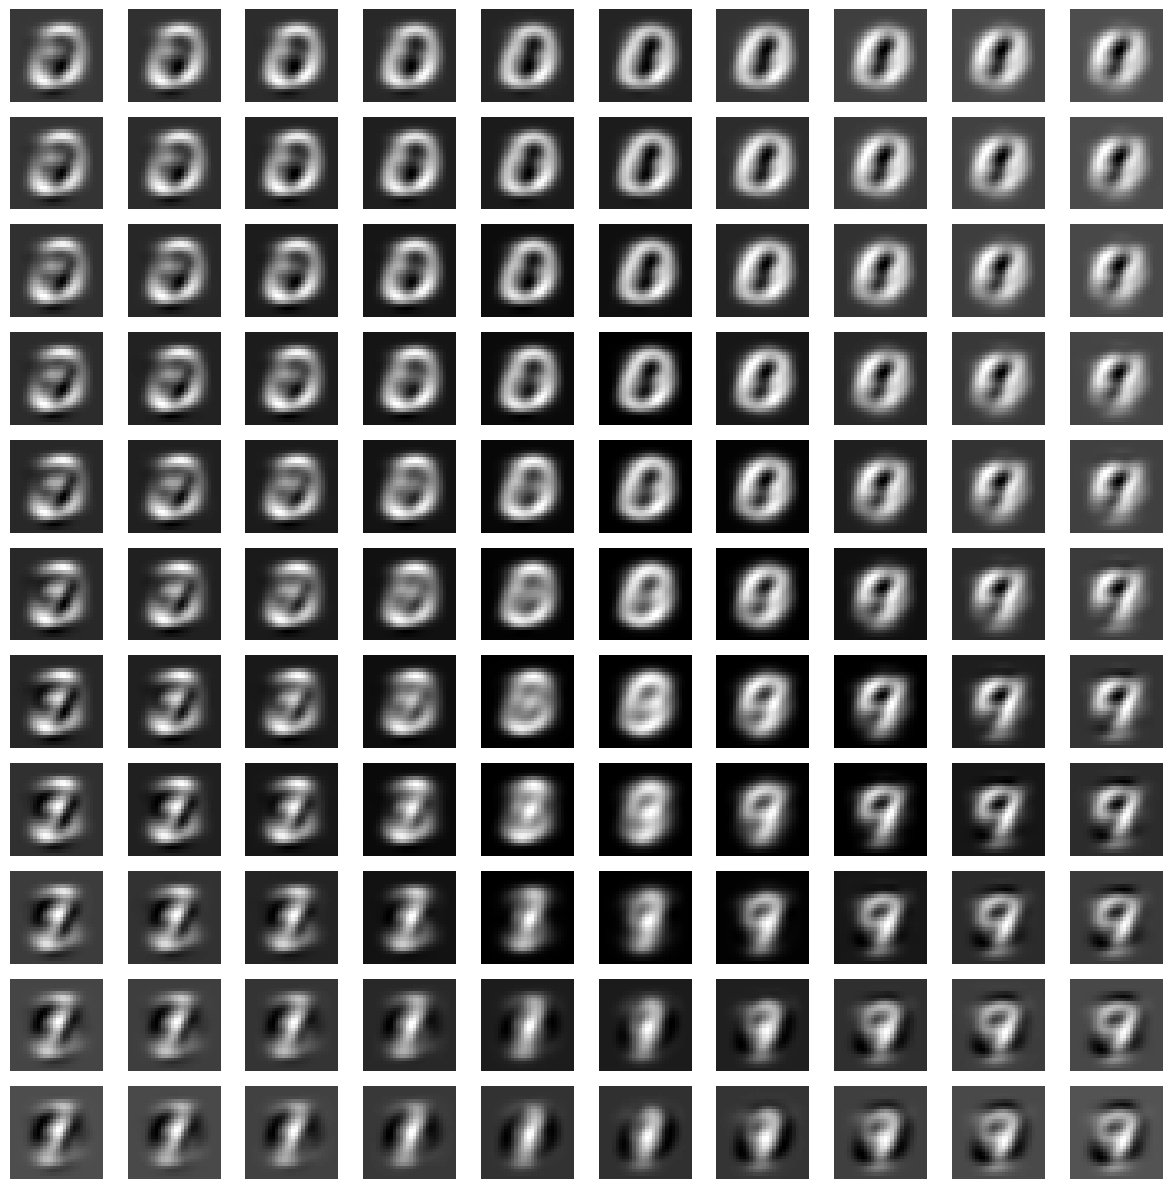

In [34]:
x_t_img = x_red.T

min_red_x = x_t_img[0].min()
max_red_x = x_t_img[0].max()
min_red_y = x_t_img[1].min()
max_red_y = x_t_img[1].max()

step_x = (max_red_x - min_red_x) / 10
step_y = (max_red_y - min_red_y) / 10

x = min_red_x

x_base_gen = []

while x < max_red_x:
  y = min_red_y
  while y < max_red_y:
    x_base_gen.append(np.array([x, y]))
    y += step_y
  x += step_x

x_base_gen = np.array(x_base_gen)


x_gen_table = pca.generate(x_base_gen)
x_gen_table = x_gen_table.reshape(x_gen_table.shape[0], 28, 28)


print(x_gen_table.shape)


display_mnist(x_gen_table, 10, 10)


[(-9.348955204851649, 4.2397839314757375), (-5.603368650082599, 5.74293159454889), (-5.599050469100766, 5.788564396665481), (-5.981002187296996, 6.213920731310243), (-5.445527901626364, 5.089137509493298), (-5.001733543122861, 4.876769613823786)] [4.529579712109129, 3.7821000815438297, 3.7958716219220823, 4.064974306202413, 3.511555137039887, 3.292834385648882] 3
[[-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -5.445527901626364, -5.001733543122861], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -5.445527901626364, -1.708899157473979], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -5.445527901626364, 1.5839352281749033], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -1.933972764586477, -5.001733543122861], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -1.933972764586477, -1.708899157473979], [-9.348955204851649, -5

IndexError: index 12 is out of bounds for axis 0 with size 12

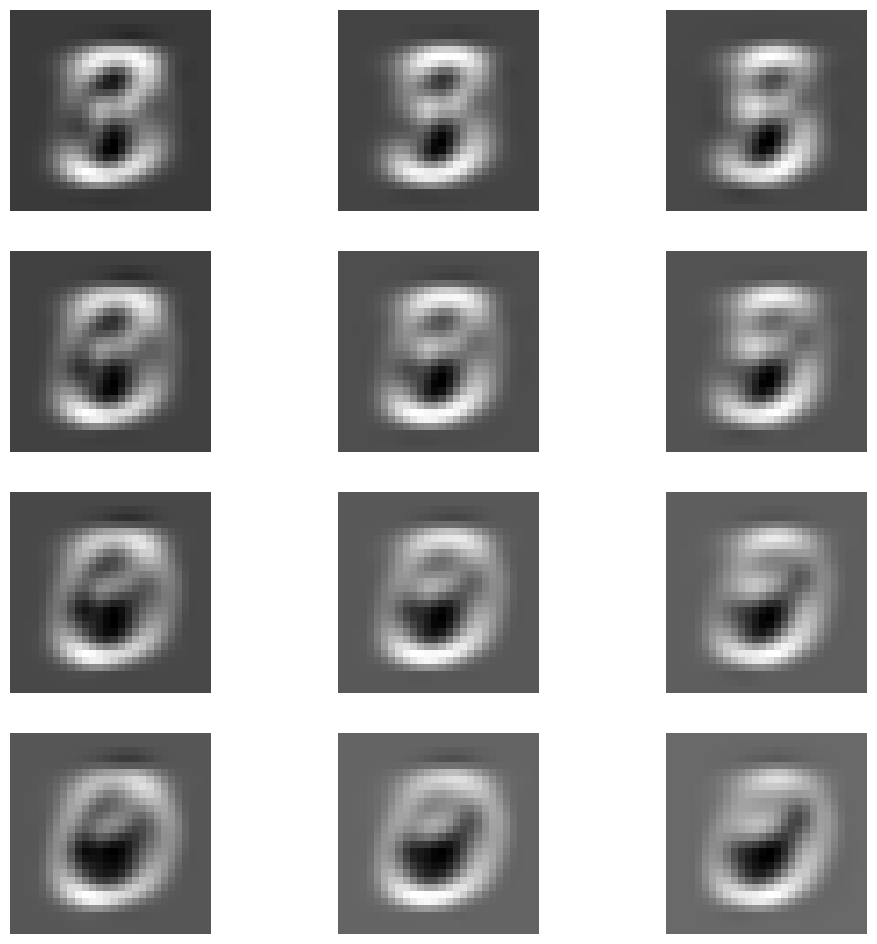

In [63]:
pca.display_table(4096)

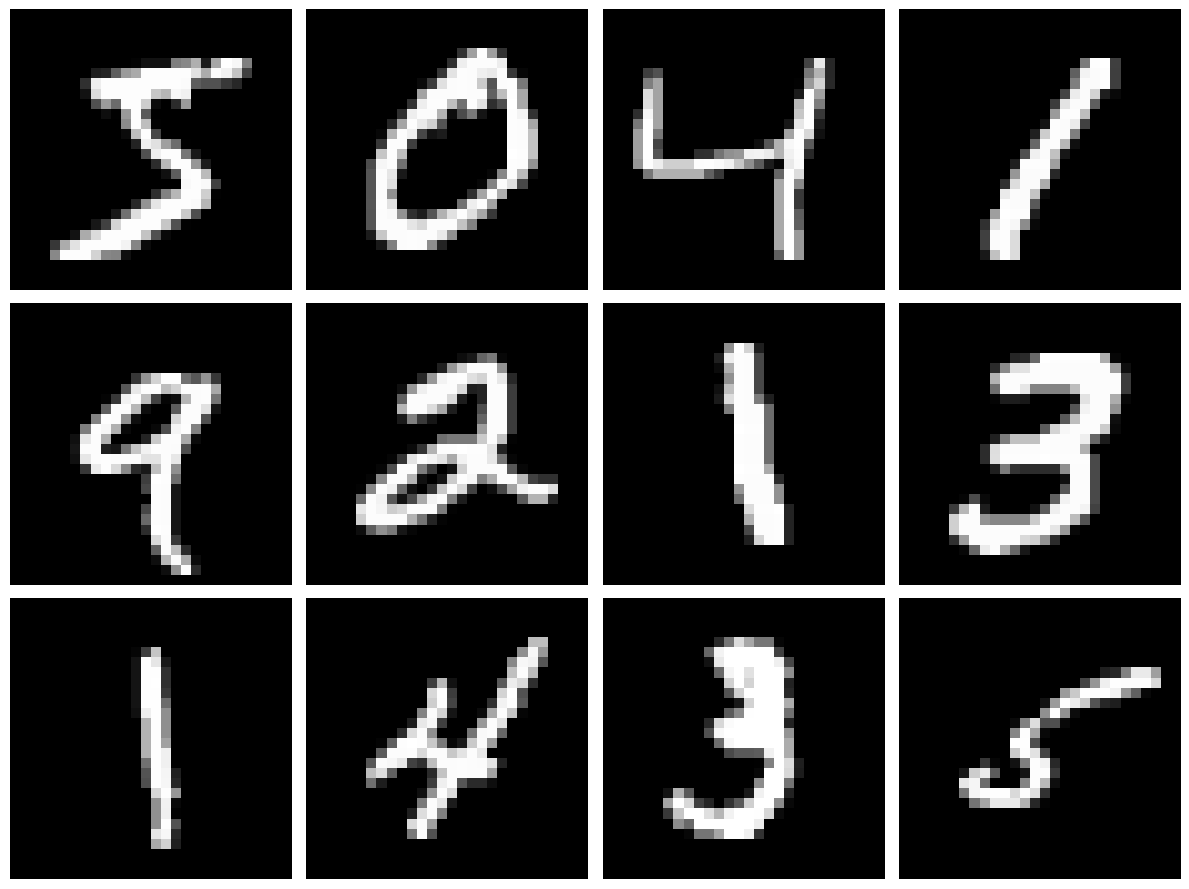

In [99]:
display_mnist(x_img[:12])

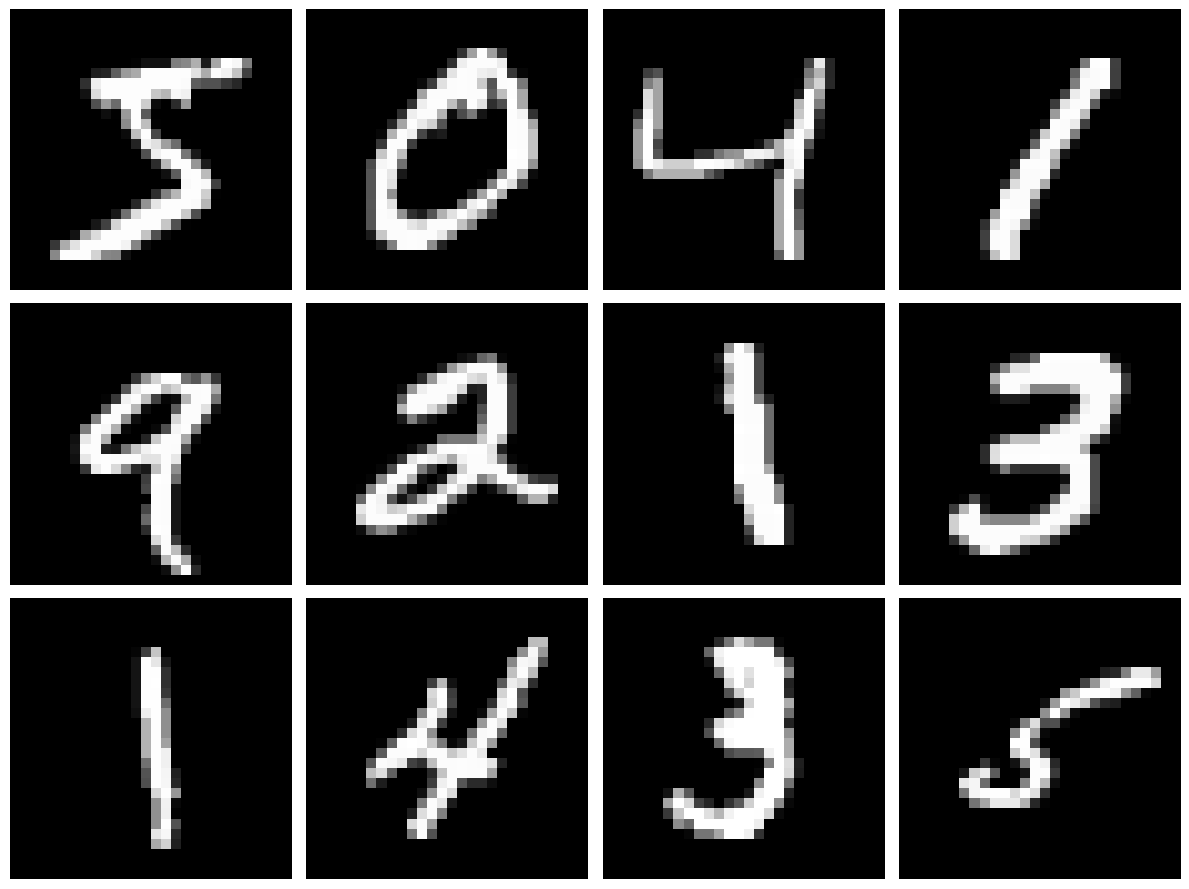

In [100]:
x_gen = pca.generate(x_red[:12])
x_gen = x_gen.reshape(x_gen.shape[0], 28, 28)
display_mnist(x_gen)